# Write Here your Experiment Title

## Data Loading and Preprocessing

### Load required libraries and specify the data folder

In [30]:
import os
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

data_folder = "\\\\izbkingston.izb.unibe.ch\\imaging.data\\mic01-imaging\\Cedric\\experimental_data"
experiment_name = "2025-03-13_TrKA1_DoseResponse_Freq"
exp_path = os.path.join(data_folder, experiment_name)


### Load analysed data from rtm-pymmcore experiment

This loads the data from the individual field of views and create one big dataframe. This dataframe is then saved in your local folder and used to plot the data.

In [ ]:
track_folder = "tracks" 
fovs = os.listdir(os.path.join(exp_path, track_folder))
fovs.sort()
dfs = []
for fov in fovs:
    track_file = os.path.join(exp_path, track_folder, fov)
    df = pd.read_parquet(track_file)
    dfs.append(df)
df = pd.concat(dfs)
df.to_parquet(os.path.join(exp_path, "exp_data.parquet"))
df.to_parquet("data.parquet")

In [26]:
df

,mean_intensity_C0_nuc,mean_intensity_C1_nuc,label,x,y,mean_intensity_C0_ring,mean_intensity_C1_ring,particle,fov,name,...,cell_line,stim,channels,channels_exposure,channel_power,fname,frame,cnr,uid,cnr_norm
0,426.900538,1222.139785,1,419.978495,654.032258,189.143498,1341.327354,0,1,1,...,optoTrkA1_high,False,"[miRFP, mScarlet3]","[150, 150]","[80, 20]",001_00000,0,1.097524,1_0,0.986359
1,1076.354705,2289.726991,2,164.647363,323.089969,201.243028,743.641434,1,1,1,...,optoTrkA1_high,False,"[miRFP, mScarlet3]","[150, 150]","[80, 20]",001_00000,0,0.324773,1_1,1.024973
2,359.341722,1845.095364,3,780.233113,400.278146,190.836283,1849.561947,2,1,1,...,optoTrkA1_high,False,"[miRFP, mScarlet3]","[150, 150]","[80, 20]",001_00000,0,1.002421,1_2,1.019336
3,429.153846,2097.568047,4,843.926036,971.349112,196.792683,936.469512,3,1,1,...,optoTrkA1_high,False,"[miRFP, mScarlet3]","[150, 150]","[80, 20]",001_00000,0,0.446455,1_3,1.055095
4,323.161074,1214.716443,5,590.060403,258.760067,184.128079,1003.054187,4,1,1,...,optoTrkA1_high,False,"[miRFP, mScarlet3]","[150, 150]","[80, 20]",001_00000,0,0.825752,1_4,1.011520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294,648.330454,1344.911447,17,479.269978,879.036717,194.896739,1545.282609,17,47,47,...,optoTrkA1_high,False,"[miRFP, mScarlet3]","[150, 150]","[80, 20]",047_00059,59,1.148985,47_17,0.920259
1295,1315.199176,959.159341,18,578.950549,387.028846,197.982143,677.745536,14,47,47,...,optoTrkA1_high,False,"[miRFP, mScarlet3]","[150, 150]","[80, 20]",047_00059,59,0.706604,47_14,1.106215
1296,407.124444,556.360000,19,501.555556,324.571852,192.947598,961.982533,10,47,47,...,optoTrkA1_high,False,"[miRFP, mScarlet3]","[150, 150]","[80, 20]",047_00059,59,1.729065,47_10,1.049550
1297,784.559124,1055.202920,20,255.684672,1010.505109,204.296296,1690.493827,16,47,47,...,optoTrkA1_high,False,"[miRFP, mScarlet3]","[150, 150]","[80, 20]",047_00059,59,1.602056,47_16,1.302416


In [ ]:
# df['fname'] = df.apply(lambda row: f"{int(row['fov']):03d}_{int(row['frame']):05d}", axis=1)


### Data clean-up
Add Cytoplasma to nuclear ratio based on measured intensities. Further normalise according to the first few frames. Remove cells which were not tracked for 80% of the frames.

In [42]:

df = pd.read_parquet("data.parquet")
df["cnr"] = df["mean_intensity_C1_ring"] / df["mean_intensity_C1_nuc"]
df["uid"] = df["fov"].astype("string") + "_" + df["particle"].astype("string")

frame_counts = df["uid"].value_counts()
threshold = 0.9 * frame_counts.max()

valid_uids = frame_counts[frame_counts >= threshold].index
df = df[df["uid"].isin(valid_uids)]

In [ ]:
NORM_UNTIL_TIMEPOINT = 10
mean_cnr_first_four_frames = df[df['frame'] < NORM_UNTIL_TIMEPOINT].groupby('uid')['cnr'].mean()
df['cnr_norm'] = df.apply(lambda row: row['cnr'] / mean_cnr_first_four_frames[row['uid']], axis=1)
df["stim_timestep"] = df["stim_timestep"].apply(str) 

In [40]:
# A quick way to look at your data is plotly express
# plot = px.line(df.query("stim_exposure == 100.0"), x="frame", y="cnr", color="uid")
# plot.add_vline(x=5, line_dash="dot", line_color="red")

In [46]:
df

,mean_intensity_C0_nuc,mean_intensity_C1_nuc,label,x,y,mean_intensity_C0_ring,mean_intensity_C1_ring,particle,fov,name,...,cell_line,stim,channels,channels_exposure,channel_power,fname,frame,cnr,uid,cnr_norm
0,426.900538,1222.139785,1,419.978495,654.032258,189.143498,1341.327354,0,1,1,...,optoTrkA1_high,False,"[miRFP, mScarlet3]","[150, 150]","[80, 20]",001_00000,0,1.097524,1_0,0.986359
1,1076.354705,2289.726991,2,164.647363,323.089969,201.243028,743.641434,1,1,1,...,optoTrkA1_high,False,"[miRFP, mScarlet3]","[150, 150]","[80, 20]",001_00000,0,0.324773,1_1,1.024973
2,359.341722,1845.095364,3,780.233113,400.278146,190.836283,1849.561947,2,1,1,...,optoTrkA1_high,False,"[miRFP, mScarlet3]","[150, 150]","[80, 20]",001_00000,0,1.002421,1_2,1.019336
3,429.153846,2097.568047,4,843.926036,971.349112,196.792683,936.469512,3,1,1,...,optoTrkA1_high,False,"[miRFP, mScarlet3]","[150, 150]","[80, 20]",001_00000,0,0.446455,1_3,1.055095
4,323.161074,1214.716443,5,590.060403,258.760067,184.128079,1003.054187,4,1,1,...,optoTrkA1_high,False,"[miRFP, mScarlet3]","[150, 150]","[80, 20]",001_00000,0,0.825752,1_4,1.011520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294,648.330454,1344.911447,17,479.269978,879.036717,194.896739,1545.282609,17,47,47,...,optoTrkA1_high,False,"[miRFP, mScarlet3]","[150, 150]","[80, 20]",047_00059,59,1.148985,47_17,0.920259
1295,1315.199176,959.159341,18,578.950549,387.028846,197.982143,677.745536,14,47,47,...,optoTrkA1_high,False,"[miRFP, mScarlet3]","[150, 150]","[80, 20]",047_00059,59,0.706604,47_14,1.106215
1296,407.124444,556.360000,19,501.555556,324.571852,192.947598,961.982533,10,47,47,...,optoTrkA1_high,False,"[miRFP, mScarlet3]","[150, 150]","[80, 20]",047_00059,59,1.729065,47_10,1.049550
1297,784.559124,1055.202920,20,255.684672,1010.505109,204.296296,1690.493827,16,47,47,...,optoTrkA1_high,False,"[miRFP, mScarlet3]","[150, 150]","[80, 20]",047_00059,59,1.602056,47_16,1.302416


## Results

### Single Stimulation Timepoint with different exposure times

#### Not normalised

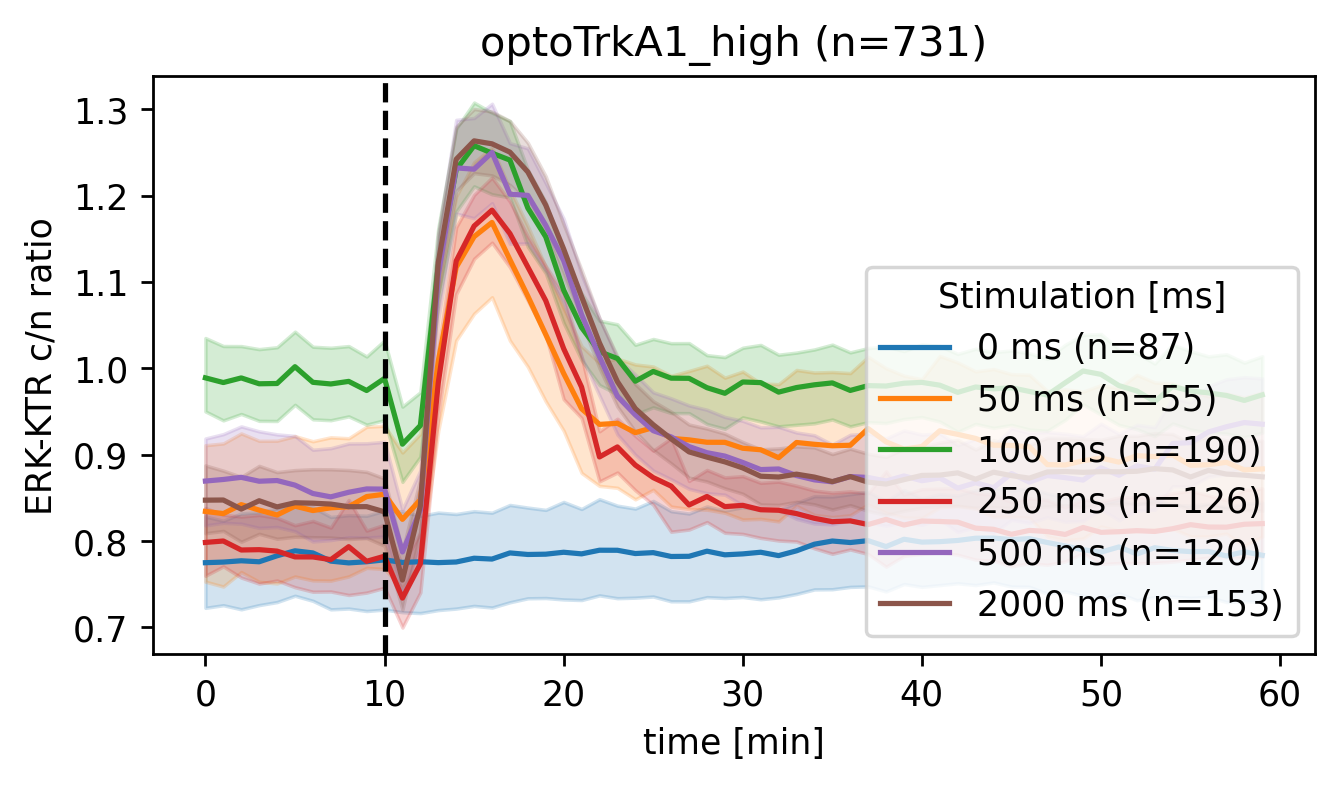

In [54]:
STIM_TIMESTEP_TO_PLOT = "[10]"
df_plot = df.query("stim_timestep == @STIM_TIMESTEP_TO_PLOT")
cell_lines = df_plot["cell_line"].unique()
df_plot.loc[:, "stim_exposure"] = df_plot.loc[:, "stim_exposure"].astype("int")

for cell_line in cell_lines: 
    plt.figure(figsize=(6, 3),dpi = 250)
    num_cells = df_plot.query("cell_line == @cell_line")["uid"].nunique()

    sns.lineplot(data=df_plot.query("cell_line == @cell_line"), x='frame', y='cnr', hue="stim_exposure", palette="tab10", errorbar=('ci',90))
    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels = []
    for label in labels:
        exposure_time = int(label)
        num_cells_exposure = df_plot.query("cell_line == @cell_line and stim_exposure == @exposure_time and stim_timestep == @STIM_TIMESTEP_TO_PLOT")["uid"].nunique()
        new_labels.append(f'{label} ms (n={num_cells_exposure})')
    plt.legend(handles, new_labels, loc='lower right', title='Stimulation [ms]')
    plt.ylabel('ERK-KTR c/n ratio')
    plt.xlabel('time [min]')
    plt.axvline(x=10, color='black', linestyle='--')
    plt.title(f"{cell_line} (n={num_cells})")
    plt.savefig(f"{cell_line}_single_erkktr.svg", bbox_inches='tight')
    plt.show()

#### Normalised 

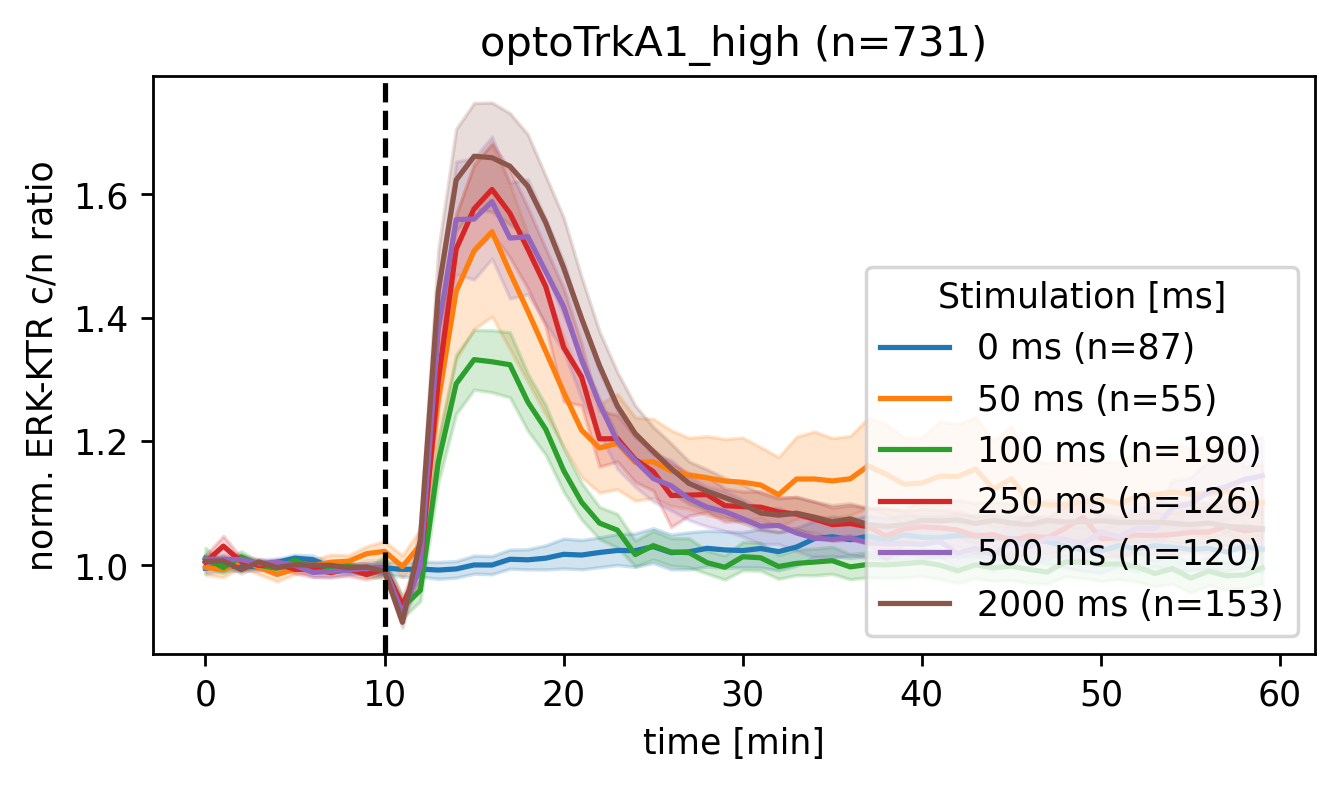

In [55]:
STIM_TIMESTEP_TO_PLOT = "[10]"
df_plot = df.query("stim_timestep == @STIM_TIMESTEP_TO_PLOT")
cell_lines = df_plot["cell_line"].unique()
df_plot.loc[:, "stim_exposure"] = df_plot.loc[:, "stim_exposure"].astype("int")

for cell_line in cell_lines: 
    plt.figure(figsize=(6, 3),dpi = 250)
    num_cells = df_plot.query("cell_line == @cell_line")["uid"].nunique()

    sns.lineplot(data=df_plot.query("cell_line == @cell_line"), x='frame', y='cnr_norm', hue="stim_exposure", palette="tab10", errorbar=('ci',90))
    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels = []
    for label in labels:
        exposure_time = int(label)
        num_cells_exposure = df_plot.query("cell_line == @cell_line and stim_exposure == @exposure_time and stim_timestep == @STIM_TIMESTEP_TO_PLOT")["uid"].nunique()
        new_labels.append(f'{label} ms (n={num_cells_exposure})')
    plt.legend(handles, new_labels, loc='lower right', title='Stimulation [ms]')
    plt.ylabel('norm. ERK-KTR c/n ratio')
    plt.xlabel('time [min]')
    plt.axvline(x=10, color='black', linestyle='--')
    plt.title(f"{cell_line} (n={num_cells})")
    plt.savefig(f"{cell_line}_single_erkktr_norm.svg", bbox_inches='tight')
    plt.show()

In [ ]:
# g = sns.FacetGrid(df, col="cell_line", height=3, aspect=1.5)
# g.map_dataframe(sns.lineplot, x='frame', y='cnr', hue="stim_exposure", palette="tab10", errorbar=('ci',90))
# g.add_legend(title='Stimulation [ms]')
# g.set_axis_labels('time [min]', 'ERK-KTR c/n ratio')
# for ax in g.axes.flat:
# 	ax.axvline(x=10, color='black', linestyle='--')
# g.fig.suptitle("optoFGFR High Expression", y=1.02)
# g.savefig("ERK-KTR_cnr.svg", bbox_inches='tight')
# plt.show()

### Multiple Stimulation

#### Not normalised

In [70]:
EXPOSURE_TO_PLOT = 100
df_plot = df.query("stim_exposure == @EXPOSURE_TO_PLOT")
df_plot["stim_timestep"].unique()

array(['[10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56\n 58]',
       '[10 30 50]', '[10 15 20 25 30 35 40 45 50 55]',
       '[10 20 30 40 50]',
       '[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33\n 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57\n 58 59]',
       '[10]'], dtype=object)

In [ ]:
df_plot.replace({"stim_timestep": {"[10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56\n 58]": "@2min."}}, inplace=True)
df_plot.replace({"stim_timestep": {"[10 30 50]": "@20min."}}, inplace=True)
df_plot.replace({"stim_timestep": {"[10 15 20 25 30 35 40 45 50 55]": "@5min."}}, inplace=True)
df_plot.replace({"stim_timestep": {"[10 20 30 40 50]": "@10min."}}, inplace=True)
df_plot.replace({"stim_timestep": {"[10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33\n 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57\n 58 59]": "@1min."}}, inplace=True)
df_plot.replace({"stim_timestep": {"[10]": "1 Stim."}}, inplace=True)

#### not normalised

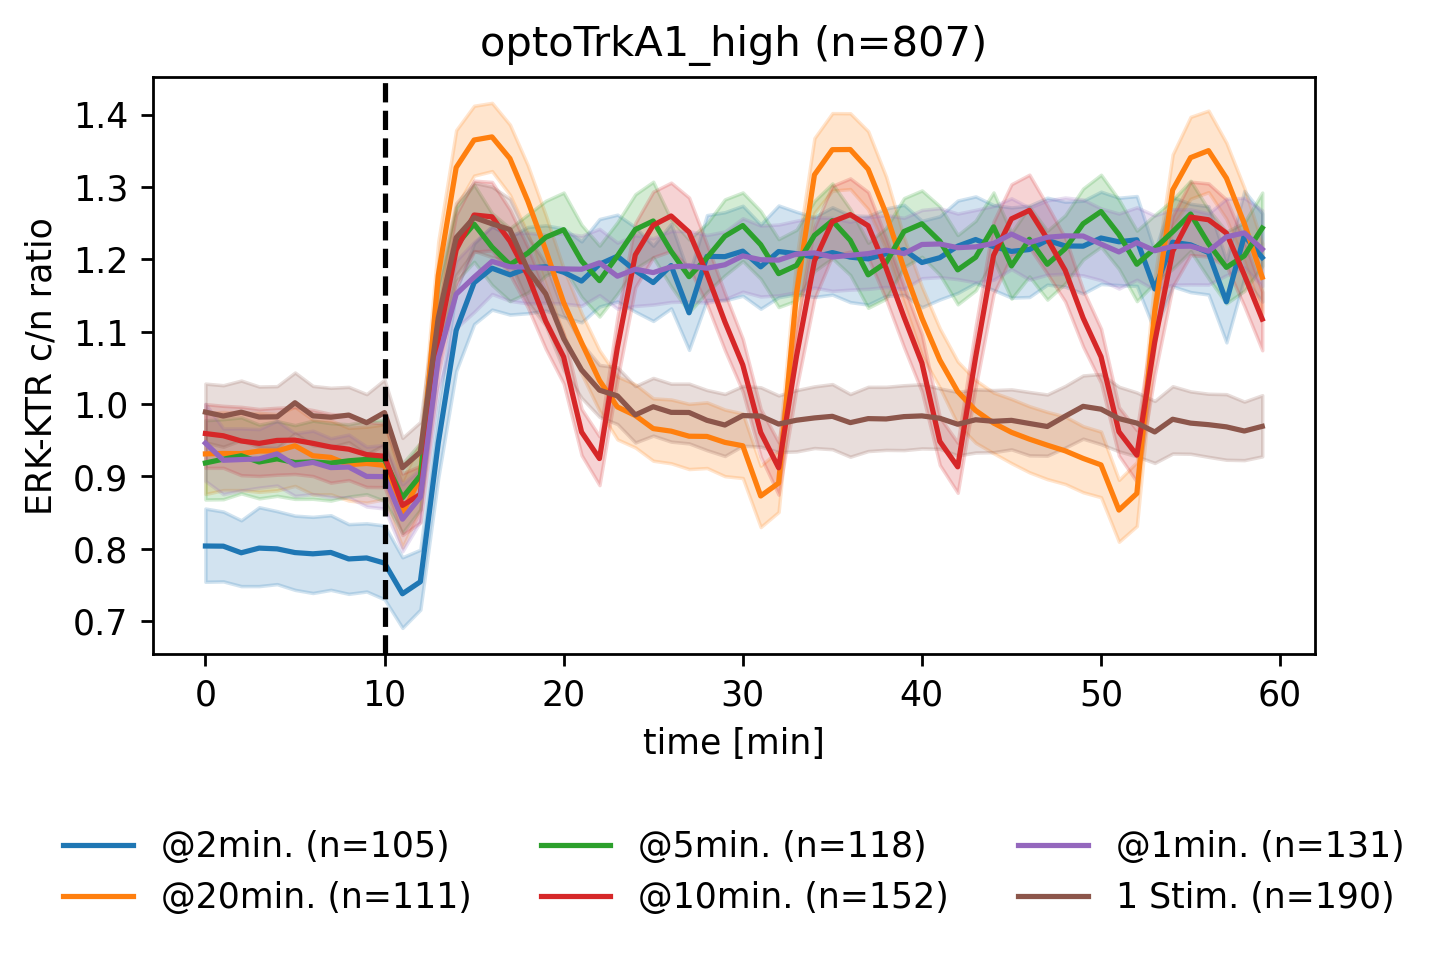

In [82]:
cell_lines = df_plot["cell_line"].unique()
df_plot.loc[:, "stim_exposure"] = df_plot.loc[:, "stim_exposure"].astype("int")

for cell_line in cell_lines: 
    plt.figure(figsize=(6, 3),dpi = 250)
    num_cells = df_plot.query("cell_line == @cell_line")["uid"].nunique()

    sns.lineplot(data=df_plot.query("cell_line == @cell_line"), x='frame', y='cnr', hue="stim_timestep", palette="tab10", errorbar=('ci',90))
    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels = []
    for label in labels:
        num_cells_exposure = df_plot.query("cell_line == @cell_line and stim_exposure == @EXPOSURE_TO_PLOT and stim_timestep == @label")["uid"].nunique()
        new_labels.append(f'{label} (n={num_cells_exposure})')
    plt.ylabel('ERK-KTR c/n ratio')
    plt.xlabel('time [min]')
    plt.axvline(x=10, color='black', linestyle='--')
    plt.title(f"{cell_line} (n={num_cells})")
    plt.legend(handles, new_labels, loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=3, frameon=False)
    plt.savefig(f"{cell_line}_multi_erkktr.svg", bbox_inches='tight')
    plt.show()

#### normalised

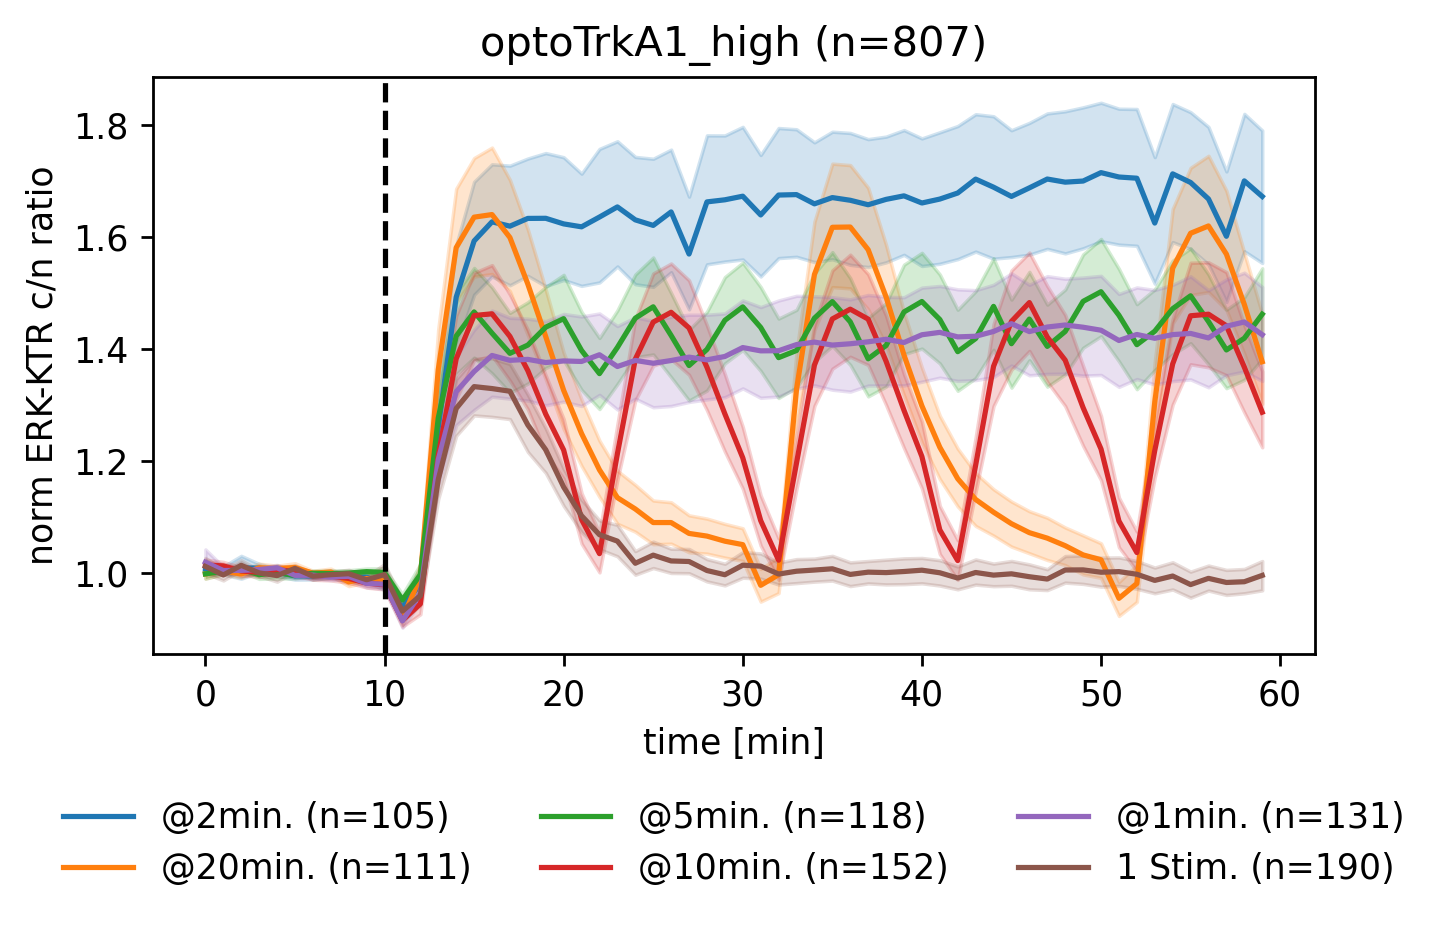

In [83]:
cell_lines = df_plot["cell_line"].unique()
df_plot.loc[:, "stim_exposure"] = df_plot.loc[:, "stim_exposure"].astype("int")

for cell_line in cell_lines: 
    plt.figure(figsize=(6, 3),dpi = 250)
    num_cells = df_plot.query("cell_line == @cell_line")["uid"].nunique()

    sns.lineplot(data=df_plot.query("cell_line == @cell_line"), x='frame', y='cnr_norm', hue="stim_timestep", palette="tab10", errorbar=('ci',90))
    handles, labels = plt.gca().get_legend_handles_labels()
    new_labels = []
    for label in labels:
        num_cells_exposure = df_plot.query("cell_line == @cell_line and stim_exposure == @EXPOSURE_TO_PLOT and stim_timestep == @label")["uid"].nunique()
        new_labels.append(f'{label} (n={num_cells_exposure})')
    plt.ylabel('norm ERK-KTR c/n ratio')
    plt.xlabel('time [min]')
    plt.axvline(x=10, color='black', linestyle='--')
    plt.title(f"{cell_line} (n={num_cells})")
    plt.legend(handles, new_labels, loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=3, frameon=False)
    plt.savefig(f"{cell_line}_multi_norm_erkktr.svg", bbox_inches='tight')
    plt.show()